In [1]:
import dress
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
import NeSST as nst

In [2]:
Nsamples=1e7

mD = sc.value("deuteron mass energy equivalent in MeV")
mT = sc.value("triton mass energy equivalent in MeV")
mn = sc.value("neutron mass energy equivalent in MeV")
mA = sc.value("alpha particle mass energy equivalent in MeV")

reaction = dress.reactions.DTNHe4Reaction()
spec_calc = dress.SpectrumCalculator(reaction, n_samples=Nsamples)

m1,m2,m3,m4 = mD,mT,mn,mA
alpha0 = (((m1+m2)**2+m3**2-m4**2)/(2*(m1+m2))-m3)
alphaK = ((m1+m2)**2-m3**2+m4**2)/(2*(m1+m2)**2)
alphaV = ((m1+m2)**2+m3**2-m4**2)/(4*(m1+m2))
beta0  = alpha0*(alpha0+2*m3)/3.

varE_2_Ts = (m1+m2)/beta0/3*1e3

C:\Users\Aidan Crilly\AppData\Roaming\Python\Python39\site-packages\dress-1.0-py3.9.egg\dress\reactions\d_t_n_he4_reaction.py:54: RuntimeWarning: overflow encountered in exp
C:\Users\Aidan Crilly\AppData\Roaming\Python\Python39\site-packages\dress-1.0-py3.9.egg\dress\reactions\d_t_n_he4_reaction.py:54: RuntimeWarning: overflow encountered in exp
C:\Users\Aidan Crilly\AppData\Roaming\Python\Python39\site-packages\dress-1.0-py3.9.egg\dress\reactions\d_t_n_he4_reaction.py:54: RuntimeWarning: overflow encountered in exp


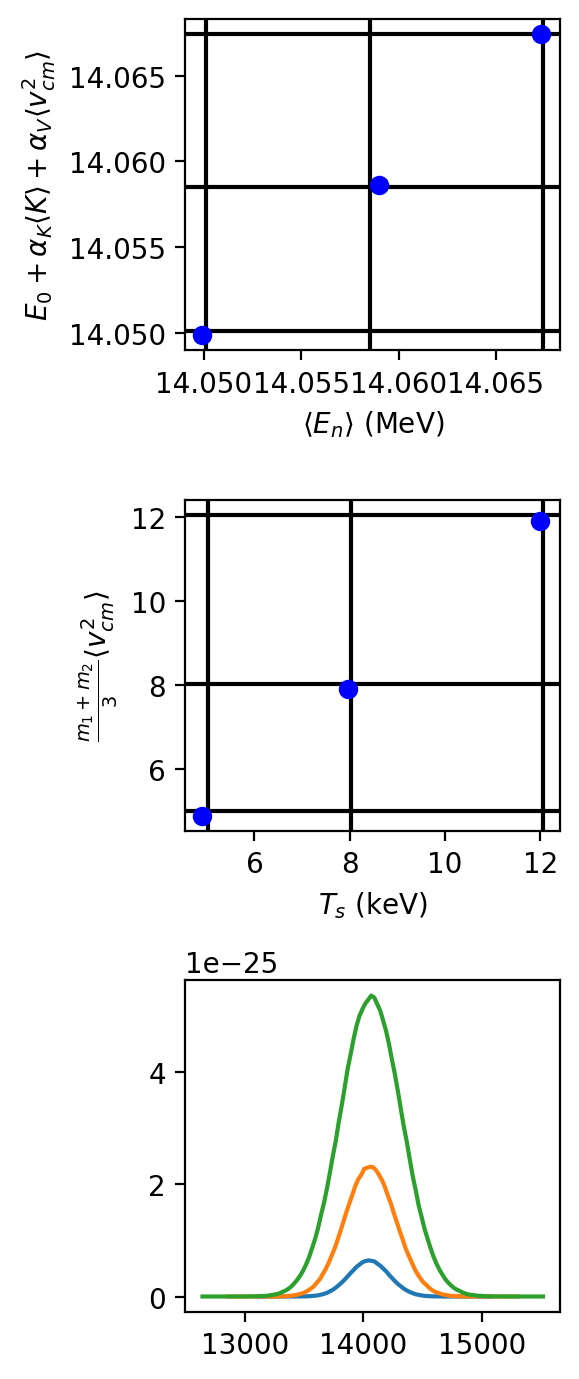

In [27]:
fig = plt.figure(dpi=200,figsize=(3,7))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

T_arr = [5.0e-3,8.0e-3,12.0e-3]

for T in T_arr:
    
    T_keV = T*1e3
    
    E_axis = np.linspace(0.0,10*T_keV,500)

    DT_primspecmean,DT_primspecvar = nst.DTprimspecmoments(T_keV)
    DT_primspecmean += 14.0284-14.021

    ax1.axhline(DT_primspecmean,c='k')
    ax1.axvline(DT_primspecmean,c='k')

    ax2.axhline(DT_primspecvar*varE_2_Ts,c='k')
    ax2.axvline(DT_primspecvar*varE_2_Ts,c='k')


    f_a = np.exp(-E_axis/T_keV)*np.sqrt(E_axis)
    f_b = np.exp(-E_axis/T_keV)*np.sqrt(E_axis)

    dist_a = dress.dists.TabulatedEnergyDistribution(E_axis, f_a, spec_calc.reactant_a, ref_dir=[0,0,1])
    dist_b = dress.dists.TabulatedEnergyDistribution(E_axis, f_b, spec_calc.reactant_b, ref_dir=[0,0,1])

    spec_calc.reactant_a.v = dist_a.sample(spec_calc.n_samples)
    spec_calc.reactant_b.v = dist_b.sample(spec_calc.n_samples)

    spectrum, bin_centers = spec_calc()
    σv = 4*np.pi*spectrum.sum()
    mean = np.average(bin_centers,weights=spectrum)
    var = np.average((bin_centers-mean)**2,weights=spectrum)
    
    v_r  = np.linalg.norm(spec_calc.reactant_a.v-spec_calc.reactant_b.v,axis=0)
    v_cm = np.linalg.norm((mD*spec_calc.reactant_a.v+mT*spec_calc.reactant_b.v)/(mD+mT),axis=0)

    K = 0.5*(mT*mD)/(mD+mT)*(v_r/sc.c)**2
    K_keV = K*1e3

    sigma_v   = np.sum(4*np.pi*v_r*reaction.calc_sigma_diff(K_keV, 0.0))
    mean_K    = np.sum(4*np.pi*v_r*K*reaction.calc_sigma_diff(K_keV, 0.0))/sigma_v
    mean_vcm2 = np.sum(4*np.pi*v_r*v_cm**2*reaction.calc_sigma_diff(K_keV, 0.0))/sigma_v
    
    spec_mean = alpha0+alphaK*mean_K+alphaV*(mean_vcm2/sc.c**2)
    spec_var  = beta0*(mean_vcm2/sc.c**2)
    
    ax1.plot(mean/1e3,spec_mean,'bo')
    ax2.plot(varE_2_Ts*var/1e6,varE_2_Ts*spec_var,'bo')
    ax3.plot(bin_centers,spectrum)

ax1.set_xlabel(r'$\langle E_n \rangle$ (MeV)')
ax1.set_ylabel(r'$E_0 + \alpha_K \langle K \rangle + \alpha_V \langle v_{cm}^2 \rangle$')
  
ax2.set_xlabel(r'$T_s$ (keV)')
ax2.set_ylabel(r'$\frac{m_1+m_2}{3}\langle v_{cm}^2 \rangle$')
    
fig.tight_layout()

In [49]:
T = 8.0e-3

v_drift_arr = np.linspace(0.0,2e6,15)

vmax = 5e6
Nv = 200

v_par_axis, v_perp_axis = np.linspace(-vmax,vmax,2*Nv),np.linspace(0.0,vmax,Nv)

v_par,v_perp = np.meshgrid(v_par_axis,v_perp_axis)

mean,spec_mean,var,spec_var,mean_K,mean_vcm2,bin_centers_arr,spectrum_arr = np.zeros_like(v_drift_arr),np.zeros_like(v_drift_arr),np.zeros_like(v_drift_arr),np.zeros_like(v_drift_arr),np.zeros_like(v_drift_arr),np.zeros_like(v_drift_arr),[],[]
for i,v_drift in enumerate(v_drift_arr):

    f_a = np.exp(-0.5*(mD/T)*((v_par-v_drift)**2+v_perp**2)/sc.c**2)
    f_b = np.exp(-0.5*(mT/T)*((v_par+v_drift)**2+v_perp**2)/sc.c**2)

    dist_a = dress.dists.TabulatedVparVperpDistribution(v_par_axis, v_perp_axis, f_a.T, spec_calc.reactant_a, ref_dir=[0,0,1])
    dist_b = dress.dists.TabulatedVparVperpDistribution(v_par_axis, v_perp_axis, f_b.T, spec_calc.reactant_b, ref_dir=[0,0,1])

    spec_calc.reactant_a.v = dist_a.sample(spec_calc.n_samples)
    spec_calc.reactant_b.v = dist_b.sample(spec_calc.n_samples)

    spectrum, bin_centers = spec_calc()
    σv = 4*np.pi*spectrum.sum()
    mean[i] = np.average(bin_centers,weights=spectrum)
    var[i] = np.average((bin_centers-mean[i])**2,weights=spectrum)
    bin_centers_arr.append(bin_centers)
    spectrum_arr.append(spectrum)
    
    v_r  = np.linalg.norm(spec_calc.reactant_a.v-spec_calc.reactant_b.v,axis=0)
    v_cm = np.linalg.norm((mD*spec_calc.reactant_a.v+mT*spec_calc.reactant_b.v)/(mD+mT),axis=0)

    K = 0.5*(mT*mD)/(mD+mT)*(v_r/sc.c)**2
    K_keV = K*1e3

    sigma_v   = np.sum(4*np.pi*v_r*reaction.calc_sigma_diff(K_keV, 0.0))
    mean_K[i]    = np.sum(4*np.pi*v_r*K*reaction.calc_sigma_diff(K_keV, 0.0))/sigma_v
    mean_vcm2[i] = np.sum(4*np.pi*v_r*v_cm**2*reaction.calc_sigma_diff(K_keV, 0.0))/sigma_v
    
    spec_mean[i] = alpha0+alphaK*mean_K[i]+alphaV*(mean_vcm2[i]/sc.c**2)
    spec_var[i]  = beta0*(mean_vcm2[i]/sc.c**2)

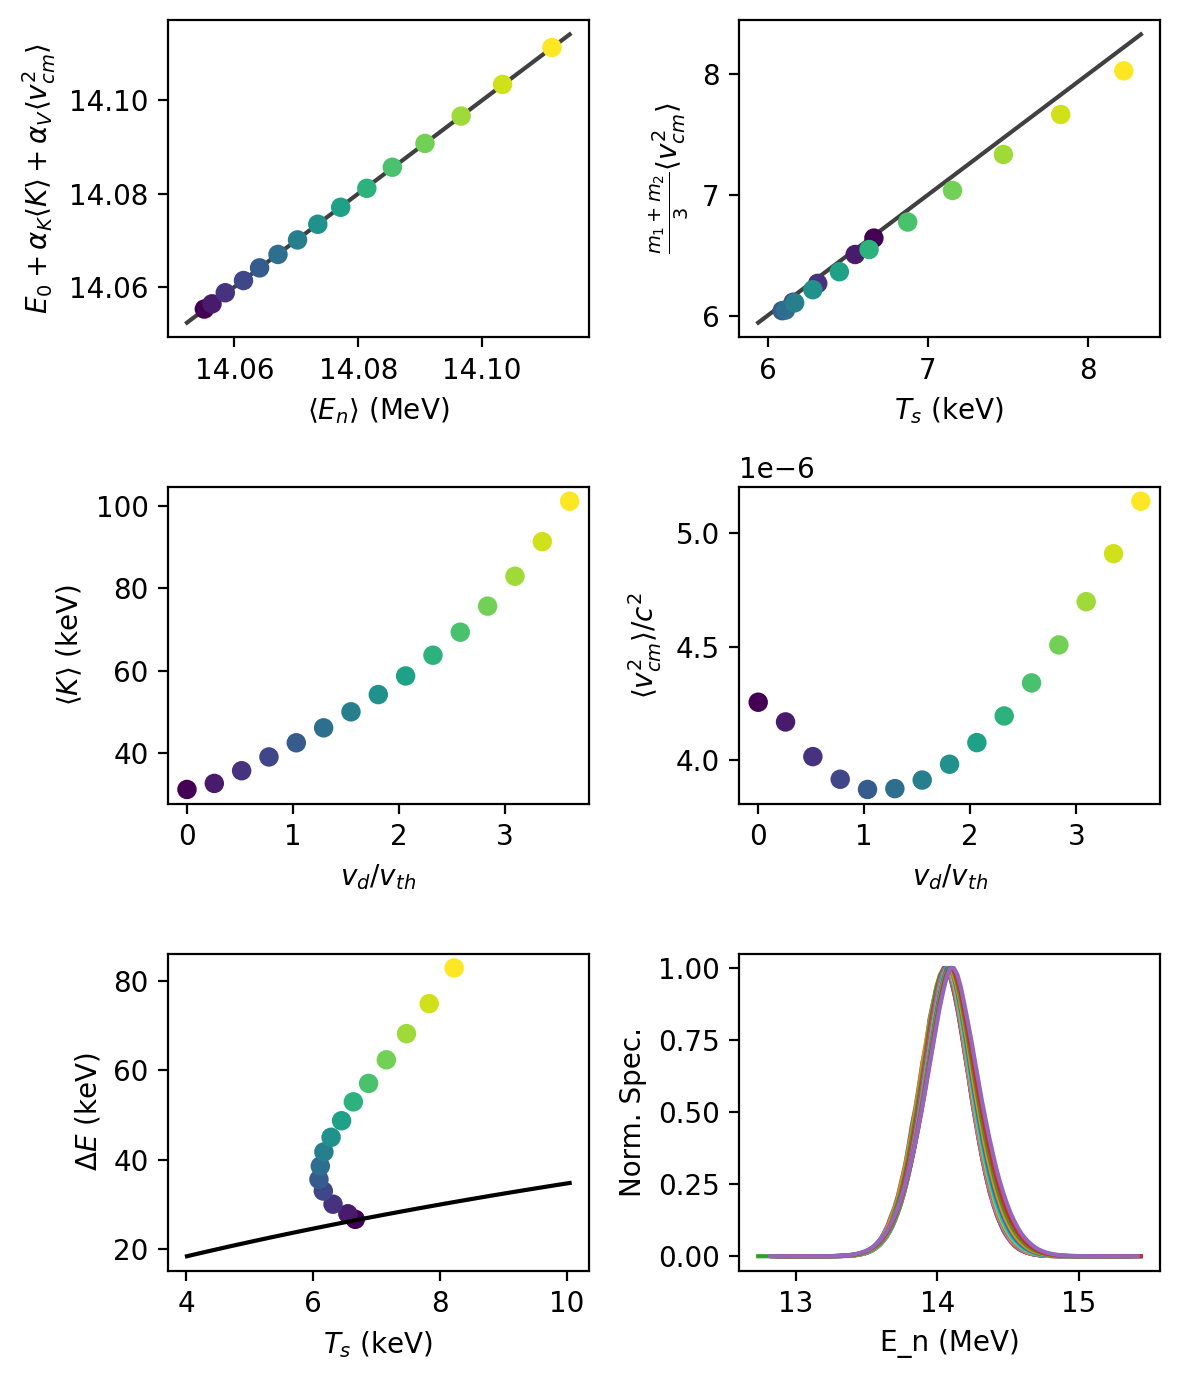

In [50]:
fig = plt.figure(dpi=200,figsize=(6,7))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)
    
vth = np.sqrt(2*T/(mD+mT))*sc.c
    
ax1.scatter(mean/1e3,spec_mean,c=v_drift_arr,marker='o')
ax2.scatter(varE_2_Ts*var/1e6,varE_2_Ts*spec_var,c=v_drift_arr,marker='o')
ax3.scatter(v_drift_arr/vth,mean_K*1e3,c=v_drift_arr,marker='o')
ax4.scatter(v_drift_arr/vth,mean_vcm2/sc.c**2,c=v_drift_arr,marker='o')
ax5.scatter(varE_2_Ts*var/1e6,mean-14.0284e3,c=v_drift_arr,marker='o')
for i in range(v_drift_arr.size):
    ax6.plot(bin_centers_arr[i]*1e-3,spectrum_arr[i]/np.amax(spectrum_arr[i]))

ax1.set_xlabel(r'$\langle E_n \rangle$ (MeV)')
ax1.set_ylabel(r'$E_0 + \alpha_K \langle K \rangle + \alpha_V \langle v_{cm}^2 \rangle$')
  
ax2.set_xlabel(r'$T_s$ (keV)')
ax2.set_ylabel(r'$\frac{m_1+m_2}{3}\langle v_{cm}^2 \rangle$')

ax3.set_xlabel(r'$v_d/v_{th}$')
ax3.set_ylabel(r'$\langle K \rangle$ (keV)')

ax4.set_xlabel(r'$v_d/v_{th}$')
ax4.set_ylabel(r'$\langle v_{cm}^2 \rangle/c^2$')

ax5.set_xlabel('$T_s$ (keV)')
ax5.set_ylabel('$\Delta E$ (keV)')

ax6.set_xlabel("E_n (MeV)")
ax6.set_ylabel("Norm. Spec.")

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

T_plot = np.linspace(4.0,10.0,100)
DT_mean,DT_var = nst.DTprimspecmoments(T_plot)

ax5.plot(varE_2_Ts*DT_var,1e3*(DT_mean-14.021),'k')

fig.tight_layout()